# Mixture Models

As a second way of analyzing customer segments, we are going to use mixture models.

(From Wikipedia) In statistics, a mixture model is a probabilistic model for representing the presence of subpopulations within an overall population, without requiring that an observed data set should identify the sub-population to which an individual observation belongs. 

It means that we are looking for subpopulations (customer segments in this case) without the presence of class/label/segment information. So it is an unsupervised learning method.

Mixture models create components (as many as we want) analogous to cluster centers of KMeans algorithm. Each observation is then represented as a weighted sum of these mixtures.

For more information on mixture models, you can refer to:

https://en.wikipedia.org/wiki/Mixture_model

In the example below, we have two normally distributions, with different means.

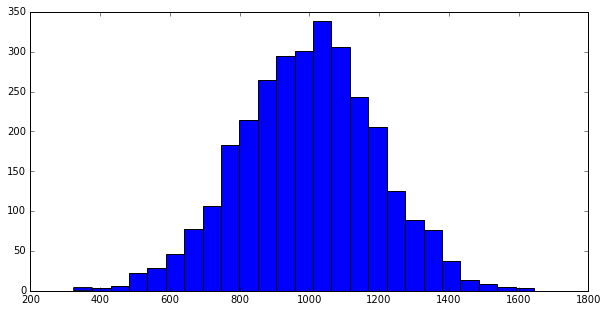

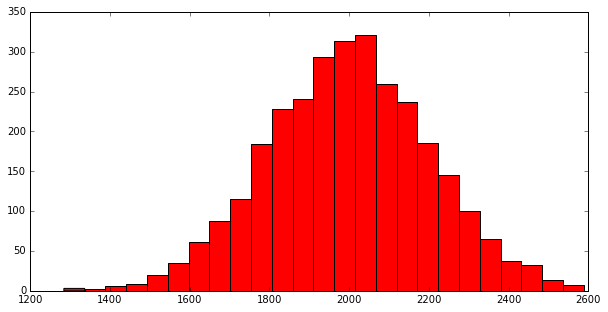

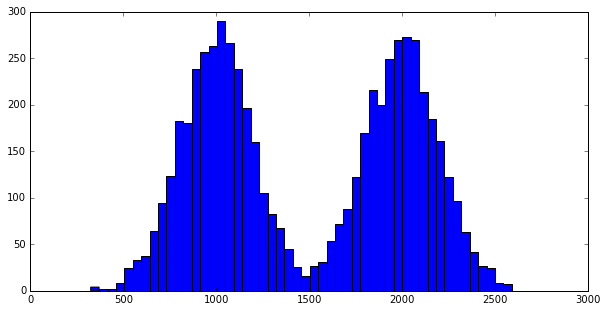

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

x1 = np.random.normal(1000,200,(3000,1))
x2 = np.random.normal(2000,200,(3000,1))
x = np.concatenate((x1,x2))

plt.figure(figsize=(10,5))
plt.hist(x1,bins=25,color= 'blue')
plt.show()
plt.figure(figsize=(10,5))
plt.hist(x2,bins=25, color='red')
plt.show()

plt.figure(figsize=(10,5))
plt.hist(x, bins = 50)
plt.show()




Let us create a mixture model with two components. We then create an array [0,1,2,...3000] and plot the probability of an observation belonging to component 1. As you can see an observation that is smaller than 1300 seem to belong to component 0 (with mean 1000). As we go from 1300 to 1700, the probability of an observation belonging to component 0 decreases (and the probability of belonging to component 1 increases). Any observation greater than 1700 will most likely belong to component 1 (with mean 2000).

Between 1300 and 1700, our observations are a **mixture** of these two components.

Means for components
[[  997.77378902]
 [ 1997.90618057]]


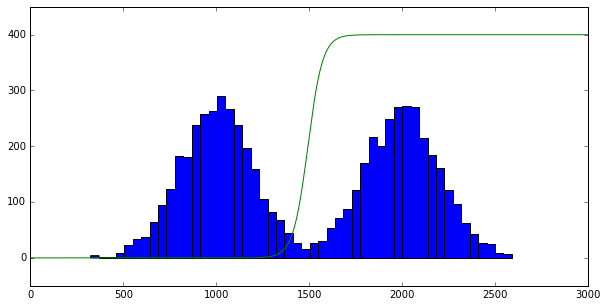

In [2]:
from sklearn.mixture import GMM

gmm = GMM(n_components=2, random_state = 0)
gmm.fit(x)

print('Means for components')
print(gmm.means_)

x_new = np.arange(0,3001,1)
x_new = x_new.reshape((3001,1))

pred = gmm.predict_proba(x_new)[:,1]


plt.figure(figsize=(10,5))
plt.hist(x, bins = 50)
plt.xlim((0,3000))
plt.ylim((-50,450))
plt.plot(pred*400)
plt.show()

We can also draw probabilities for both components to better illustrate the idea of mixture.

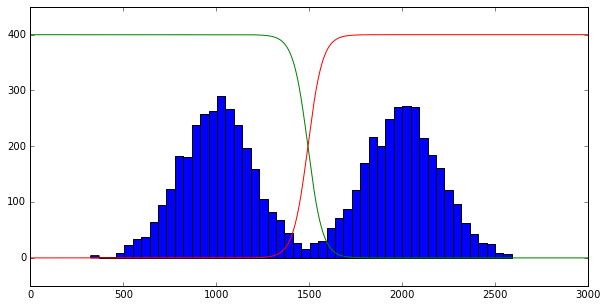

In [3]:
pred = gmm.predict_proba(x_new)

plt.figure(figsize=(10,5))
plt.hist(x, bins = 50)
plt.xlim((0,3000))
plt.ylim((-50,450))
plt.plot(pred*400)
plt.show()

As you can see if a number is below 1500, then it is more likely to belong to the component with mean 1000. After that number, a number is more likely to belong to component with mean 2000, as we would expect, since the distributions only differ in their means.

We can also carry the same analysis with a third distribution (with mean 3000) and a third component.

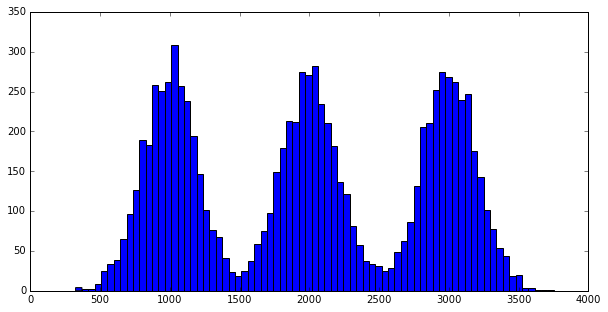

Means for components
[[  995.78211556]
 [ 3008.39272406]
 [ 1998.87952371]]


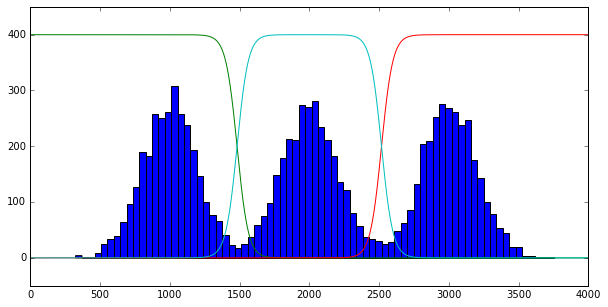

In [4]:
x3 = np.random.normal(3000,200,(3000,1))
x = np.concatenate((x1,x2,x3))

plt.figure(figsize=(10,5))
plt.hist(x, bins = 75)
plt.show()

gmm = GMM(n_components=3, random_state = 0)
gmm.fit(x)

print('Means for components')
print(gmm.means_)

x_new = np.arange(0,4000,1)
x_new = x_new.reshape((4000,1))

pred = gmm.predict_proba(x_new)


plt.figure(figsize=(10,5))
plt.hist(x, bins = 75)
plt.xlim((0,4000))
plt.ylim((-50,450))
plt.plot(pred*400)
plt.show()



Can you interpret the figure above?

# Customer Segmentation

We are going to carry customer segmentation analysis using mixture models. First, we load and prepare data as we did in the previous course.

In [5]:
print(__doc__)
%matplotlib inline
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GMM
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans
import pandas as pd 
from sklearn.metrics import roc_auc_score
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
sns.set_style("whitegrid")

df_train = pd.read_csv('Transactions_2015.csv')

df_train.fillna(0,inplace = True)

negative_cells = df_train<0

df_train = df_train[negative_cells.sum(axis=1) < 1]

df_sum = df_train[['Category_' + str(i) for i in [1,2,3,4,5,6]]].sum(axis=1)

df_train['sum'] = df_sum

df_train = df_train[df_train['sum'] <= np.percentile(df_train['sum'], 99)]

col_cat = [ u'Category_1', u'Category_2', u'Category_3', u'Category_4', u'Category_5', u'Category_6']
#col_mon = [ u'last_amo_6', u'last_amo_5', u'last_amo_4', u'last_amo_3', u'last_amo_2', u'last_amo_1']

df_train_cat = df_train[col_cat]
#df_train_mon = df_train[col_mon]

df_train_cat.columns = ['Et-Balik', 'Kahvaltilik', 'Gida-Sekerleme', 'Sebze', 'Meyve', 'Deterjan']

df_train_cat['Sebze-Meyve'] = df_train_cat['Sebze'] + df_train_cat['Meyve']

df_train_cat.drop(['Sebze', 'Meyve'], axis=1, inplace=True)
df_train_cat = df_train_cat[['Et-Balik', 'Kahvaltilik', 'Gida-Sekerleme','Sebze-Meyve',  'Deterjan']]

df_train_cat_pct = df_train_cat.div(df_train_cat.sum(axis=1), axis=0)


Automatically created module for IPython interactive environment


C:\Users\byuceoglu\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
C:\Users\byuceoglu\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\byuceoglu\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
from sklearn.mixture import GMM

gmm = GMM(n_components=5, random_state=0)
gmm.fit(df_train_cat_pct)
means = gmm.means_

print(means)

[[ 0.1639955   0.69757303  0.08461312  0.04605483  0.00776351]
 [ 0.20923848  0.17276085  0.25021032  0.30176841  0.06602194]
 [ 0.63569701  0.19396779  0.08315123  0.07560824  0.01157574]
 [ 0.29144092  0.12952344  0.44888457  0.10483327  0.02531779]
 [ 0.33819992  0.44695305  0.15028705  0.05318815  0.01137182]]


Based on our previous knowledge, we can draw the components as we did the cluster centers in KMeans.

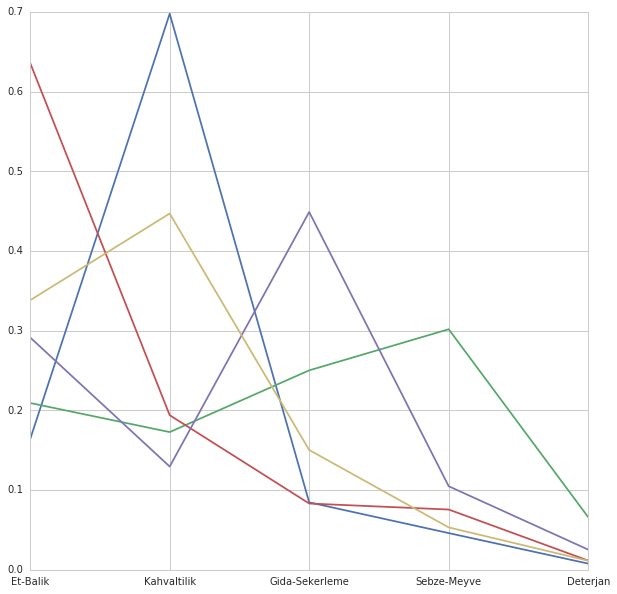

In [7]:
plt.figure(figsize=(10,10))
plt.plot(means.transpose())

plt.xticks(np.arange(5), df_train_cat_pct.columns)
plt.show()




The components look consistent with cluster centers from KMeans. However, in mixture models each observation consists of a mixture of the components.

Now let us examine what we did in more detail in order to understand the idea of mixture. We take the customer with index 0 and plot the most likely component.

C:\Users\byuceoglu\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\byuceoglu\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[4]


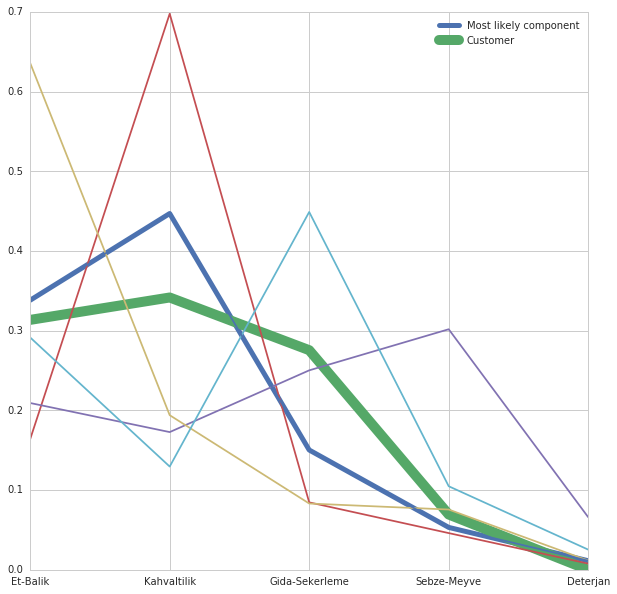

In [8]:
print(gmm.predict(df_train_cat_pct.iloc[0,:]))

component = gmm.predict(df_train_cat_pct.iloc[0,:])[0]

plt.figure(figsize=(10,10))           
plt.plot(means[component,:].transpose(), linewidth=5, label = 'Most likely component')
plt.plot(df_train_cat_pct.iloc[0,:].values, linewidth = 10, label='Customer')
plt.plot(means.transpose())
plt.xticks(np.arange(5), df_train_cat_pct.columns)
plt.legend()
plt.show()


Unlike KMeans, mixture models allows us to use predict_proba function. We can think of the probabilities that we obtain as the weight of that component in that specific customer profile. We can analyse customer with index -2 (second last customer) to see an example of this. In the example components 0 and 4 are more likely than others (0.61 and 0.39). Let us see whether we can visualize this.

C:\Users\byuceoglu\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\byuceoglu\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  6.12738986e-01   4.45352791e-08   1.26818762e-09   9.74841812e-31
    3.87260968e-01]]


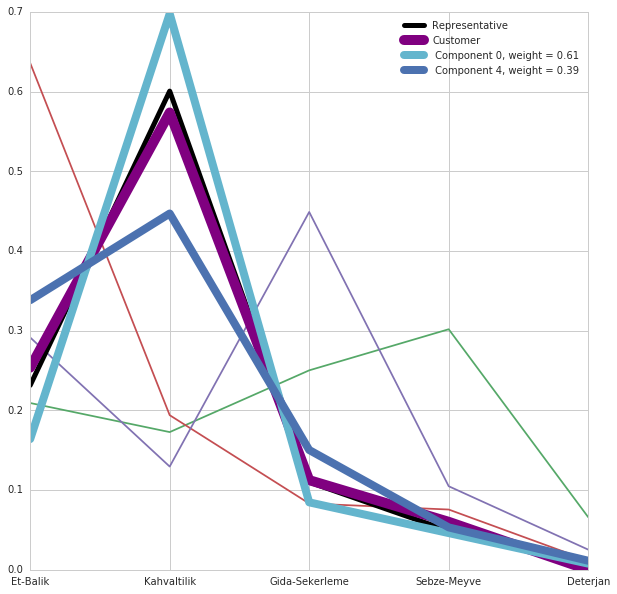

In [9]:
print(gmm.predict_proba(df_train_cat_pct.iloc[-2,:]))
# We use probabilities as weights in order to determine the representation of the customer with respect to components.

representative = np.dot(gmm.predict_proba(df_train_cat_pct.iloc[-2,:]),means)      

plt.figure(figsize=(10,10))
plt.plot(means.transpose())
plt.plot(representative.transpose(), linewidth=5, c='k', label = 'Representative')
plt.plot(df_train_cat_pct.iloc[-2,:].values, linewidth = 10, c='purple', label = 'Customer')

plt.plot(means[0,:], linewidth = 8, label = ' Component 0, weight = 0.61')
plt.plot(means[4,:], linewidth = 8, label = ' Component 4, weight = 0.39')

plt.xticks(np.arange(5), df_train_cat_pct.columns)
plt.legend()
plt.show()